In [ ]:
# Import libraries and load dataset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Load dataset
df = pd.read_csv('kidney_disease.csv')

# Map target to numeric
df['class'] = df['classification'].map({'ckd':1, 'notckd':0})

# Drop id column
df.drop('id', axis=1, inplace=True)

# Replace placeholders with NaN
df.replace(['\t?', '?', '\t'], np.nan, inplace=True)

# Convert numeric columns to float
numeric_cols = ['age','bp','sg','al','su','bgr','bu','sc','sod','pot','hemo','pcv','wc','rc']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill missing values
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)

print(df.head())
df.info()


    age    bp     sg   al   su     rbc        pc         pcc          ba  \
0  48.0  80.0  1.020  1.0  0.0  normal    normal  notpresent  notpresent   
1   7.0  50.0  1.020  4.0  0.0  normal    normal  notpresent  notpresent   
2  62.0  80.0  1.010  2.0  3.0  normal    normal  notpresent  notpresent   
3  48.0  70.0  1.005  4.0  0.0  normal  abnormal     present  notpresent   
4  51.0  80.0  1.010  2.0  0.0  normal    normal  notpresent  notpresent   

     bgr  ...      wc   rc  htn   dm  cad  appet   pe  ane classification  \
0  121.0  ...  7800.0  5.2  yes  yes   no   good   no   no            ckd   
1  121.0  ...  6000.0  4.8   no   no   no   good   no   no            ckd   
2  423.0  ...  7500.0  4.8   no  yes   no   poor   no  yes            ckd   
3  117.0  ...  6700.0  3.9  yes   no   no   poor  yes  yes            ckd   
4  106.0  ...  7300.0  4.6   no   no   no   good   no   no            ckd   

  class  
0   1.0  
1   1.0  
2   1.0  
3   1.0  
4   1.0  

[5 rows x 26 column

In [ ]:
# Check for nulls and target distribution
print(df.isnull().sum())
print(df['class'].value_counts())


age               0
bp                0
sg                0
al                0
su                0
rbc               0
pc                0
pcc               0
ba                0
bgr               0
bu                0
sc                0
sod               0
pot               0
hemo              0
pcv               0
wc                0
rc                0
htn               0
dm                0
cad               0
appet             0
pe                0
ane               0
classification    0
class             0
dtype: int64
class
1.0    250
0.0    150
Name: count, dtype: int64


In [ ]:
# Encode categorical variables and apply SMOTE
cat_cols = ['rbc','pc','pcc','ba','htn','dm','cad','appet','pe','ane']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

X = df.drop(['class','classification'], axis=1, errors='ignore')
y = df['class']

# Balance dataset
oversample = SMOTE(random_state=42)
X_resampled, y_resampled = oversample.fit_resample(X, y)
print(y_resampled.value_counts())


class
1.0    250
0.0    250
Name: count, dtype: int64


In [ ]:
# Train-test split and hyperparameter tuning
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 500],
    'max_depth': [3, 5],
    'min_child_weight': [1, 3, 5],
}

xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train_scaled, y_train)
print("Best Hyperparameters:", grid_search.best_params_)


Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 500}


In [ ]:
# Ensemble model
xgb_classifier = XGBClassifier(
    learning_rate=0.01,
    max_depth=3,
    min_child_weight=1,
    n_estimators=500,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

lgb_classifier = LGBMClassifier(random_state=42)
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=42)

ensemble_classifier = VotingClassifier(
    estimators=[('xgb', xgb_classifier), ('lgb', lgb_classifier), ('rf', rf_classifier)],
    voting='soft'
)
ensemble_classifier.fit(X_train_scaled, y_train)


[LightGBM] [Info] Number of positive: 174, number of negative: 176
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 350, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497143 -> initscore=-0.011429
[LightGBM] [Info] Start training from score -0.011429
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

,estimators,"[('xgb', ...), ('lgb', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None


Ensemble Accuracy: 99.33%

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99        74
         1.0       1.00      0.99      0.99        76

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



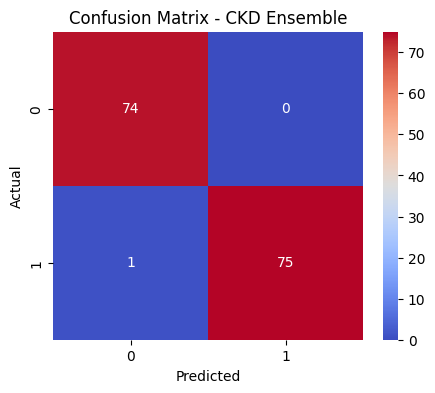

In [ ]:
# Evaluate ensemble
y_pred = ensemble_classifier.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print(f'Ensemble Accuracy: {acc*100:.2f}%')
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='coolwarm')
plt.title('Confusion Matrix - CKD Ensemble')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
# Individual model performance
models = {'XGBoost': xgb_classifier, 'LightGBM': lgb_classifier, 'RandomForest': rf_classifier}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    pred = model.predict(X_test_scaled)
    print(f'{name} Accuracy: {accuracy_score(y_test, pred)*100:.2f}%')


XGBoost Accuracy: 99.33%
[LightGBM] [Info] Number of positive: 174, number of negative: 176
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 350, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497143 -> initscore=-0.011429
[LightGBM] [Info] Start training from score -0.011429
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit